# KERAS and MNIST

In [2]:
import matplotlib.pyplot as plt
import numpy as np

We’ll apply the ideas we just learned to a neural network that does character recognition using the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database). This is a set of handwritten digits (0–9) represented as a 28×28 pixel grayscale image.

There are 2 datasets, the training set with 60,000 images and the test set with 10,000 images.

In [3]:
import keras

```{important}
Keras requires a backend, which can be [tensorflow](https://www.tensorflow.org/), [pytorch](https://pytorch.org/), or [jax](https://docs.jax.dev/en/latest/index.html).

By default, it will assume tensorflow.

This notebook has been tested with both pytorch and tensorflow.
```

````{tip}
To have keras use pytorch, set the environment variable `KERAS_BACKEND` as:
```
export KERAS_BACKEND="torch"
```
````

We follow the example for setting up the network:
https://github.com/Vict0rSch/deep_learning/tree/master/keras/feedforward

````{note}
For visualization of the network, you need to have `pydot` installed.
````

## The MNIST data

The keras library can download the MNIST data directly and provides a function to give us both the training and test images and the corresponding digits.  This is already in a format that Keras wants, so we don't use the classes that we defined earlier.

In [4]:
from keras.datasets import mnist

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

As before, the training set consists of 60000 digits represented as a 28x28 array (there are no color channels, so this is grayscale data).  They are also integer data.

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_train.dtype

dtype('uint8')

Let's look at the first digit and the "y" value (target) associated with it&mdash;that's the correct answer.

5


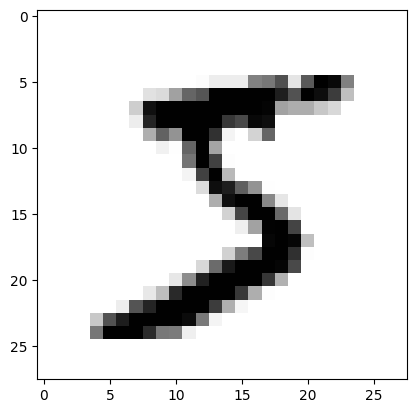

In [8]:
plt.imshow(X_train[0], cmap="gray_r")
print(y_train[0])

## Preparing the Data

The neural network takes a 1-d vector of input and will return a 1-d vector of output.  We need to convert our data to this form.

We'll scale the image data to fall in [0, 1) and the numerical output to be categorized as an array.  Finally, we need the input data to be one-dimensional, so we fill flatten the 28x28 images into a single 784 vector.

In [9]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = np.reshape(X_train, (60000, 784))
X_test = np.reshape(X_test, (10000, 784))

In [10]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

We will use categorical data.  Keras includes routines to categorize data.  In our case, since there are 10 possible digits, we want to put the output into 10 categories (represented by 10 neurons)

In [11]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Now let's look at the target for the first training digit.  We know from above that it was '5'.  Here we see that there is a `1` in the index corresponding to `5` (remember we start counting at `0` in python).

In [12]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

## Build the Neural Network

Now we'll build the neural network.  We will have 2 hidden layers, and the number of neurons will look like:

784 &rarr; 500 &rarr; 300 &rarr; 10

### Layers

Let's start by setting up the layers.  For each layer, we tell keras the number of output neurons.  It infers the number of inputs from the previous layer (with the exception of the input layer, where we need to tell it what to expect as input).

Properties on the layers:

  * Dense layers: We will use a _dense_ network.  This means that all neurons in one
    layer are connected to all neurons in the next layer (sometimes the
    term "fully-connected" is used here).

  * Activation function: We previously used the _sigmoid_ function.  Now we'll
    use [_rectified linear unit_](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (see  also http://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#relu) for all but the last layer.  

    For the very last layer (the output layer), we use a [softmax activation](https://en.wikipedia.org/wiki/Softmax_function).  This is commonly used with categorical data (like we have) and has the nice property that all of entries add to 1 (so we can interpret them as probabilities).

    See https://keras.io/api/layers/activations/ for a list of activation functions supported.

  * Dropout: for some of the layers, we will specify a _dropout_.  This means that
    we will ignore some of the neurons in a layer during training (randomly selected
    at the specified probability).  This can help present overfitting of the network.
    
    Here's a nice discussion: https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input

model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(500, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(300, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation="softmax"))

### Loss function

We need to specify what we want to optimize and how we are going to do it.  

Recall: the loss (or cost) function measures how well our predictions match the expected target.
Previously we were using the sum of the squares of the error.

For categorical data, like we have, the "cross-entropy" metric is often used.  See here for an explanation: https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/

### Optimizer

We also need to specify an optimizer.  This could be gradient descent, as we used before.  Here's a list of the optimizers supoprted by keras: https://keras.io/api/optimizers/  We'll use `RMPprop`, which builds off of gradient descent and includes some momentum.

Finally, we need to specify a metric that is evaluated during training and testing.  We'll use `"accuracy"` here.  This means that we'll see the accuracy of our model reported as we are training and testing.

More details on these options is here: https://keras.io/api/models/model/

In [14]:
from keras.optimizers import RMSprop

rms = RMSprop()
model.compile(loss='categorical_crossentropy',
              optimizer=rms, metrics=['accuracy'])

### Network summary

Let's take a look at the network:

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 500)            │       392,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │       150,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,810 (2.08 MB)

 Trainable params: 545,810 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

We see that there are > 500k parameters that we will be training

# Train

For training, we pass in the inputs and target and the number of epochs to run and it will optimize the network by adjusting the weights between the nodes in the layers.

The number of epochs is the number of times the entire data set is passed forward and backward through the network.  The batch size is the number of training pairs you pass through the network at a given time.  You update the parameter in your model (the weights) once for each batch.  This makes things more efficient and less noisy.

In [16]:
epochs = 20
batch_size = 256
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_data=(X_test, y_test), verbose=2)

Epoch 1/20
235/235 - 1s - 6ms/step - accuracy: 0.8868 - loss: 0.3697 - val_accuracy: 0.9540 - val_loss: 0.1459
Epoch 2/20
235/235 - 1s - 6ms/step - accuracy: 0.9529 - loss: 0.1573 - val_accuracy: 0.9682 - val_loss: 0.1009
Epoch 3/20
235/235 - 1s - 6ms/step - accuracy: 0.9642 - loss: 0.1172 - val_accuracy: 0.9735 - val_loss: 0.0821
Epoch 4/20
235/235 - 1s - 6ms/step - accuracy: 0.9702 - loss: 0.0959 - val_accuracy: 0.9793 - val_loss: 0.0693
Epoch 5/20
235/235 - 1s - 6ms/step - accuracy: 0.9748 - loss: 0.0826 - val_accuracy: 0.9788 - val_loss: 0.0682
Epoch 6/20
235/235 - 1s - 6ms/step - accuracy: 0.9772 - loss: 0.0732 - val_accuracy: 0.9815 - val_loss: 0.0638
Epoch 7/20
235/235 - 1s - 6ms/step - accuracy: 0.9801 - loss: 0.0646 - val_accuracy: 0.9813 - val_loss: 0.0620
Epoch 8/20
235/235 - 1s - 6ms/step - accuracy: 0.9814 - loss: 0.0592 - val_accuracy: 0.9808 - val_loss: 0.0636
Epoch 9/20
235/235 - 2s - 7ms/step - accuracy: 0.9832 - loss: 0.0540 - val_accuracy: 0.9803 - val_loss: 0.0641
E

## Test

keras has a routine, `evaluate()` that can take the inputs and targets of a test data set and return the loss value and accuracy (or other defined metrics) on this data.

Here we see we are > 98% accurate on the test data&mdash;this is the data that the model has never seen before (and was not trained with).

In [17]:
loss_value, accuracy = model.evaluate(X_test, y_test, batch_size=16)
print(accuracy)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9806 - loss: 0.0810
0.9842000007629395


## Predicting

Suppose we simply want to ask our neural network to predict the target for an input.  We can use the `predict()` method to return the category array with the predictions.  We can then use `np.argmax()` to select the most probable.

In [18]:
np.argmax(model.predict(np.array([X_test[0]])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


np.int64(7)

In [19]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

Now let's loop over the test set and print out what we predict vs. the true answer for those we get wrong.  We can also plot the image of the digit.

test 8: prediction = 6, truth is 5


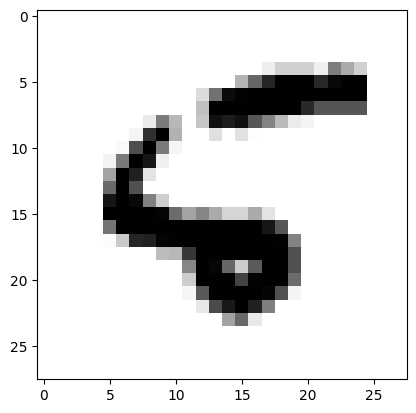

test 247: prediction = 2, truth is 4


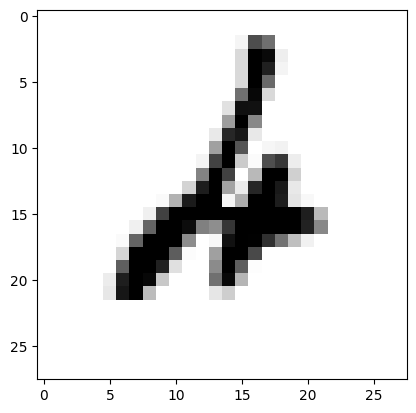

test 321: prediction = 7, truth is 2


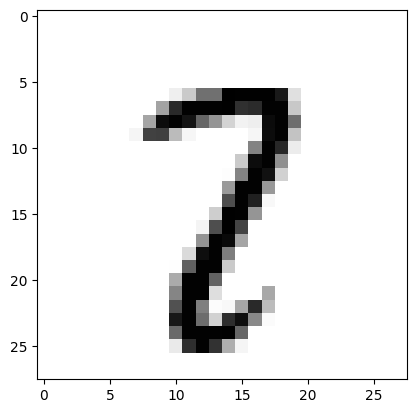

test 340: prediction = 3, truth is 5


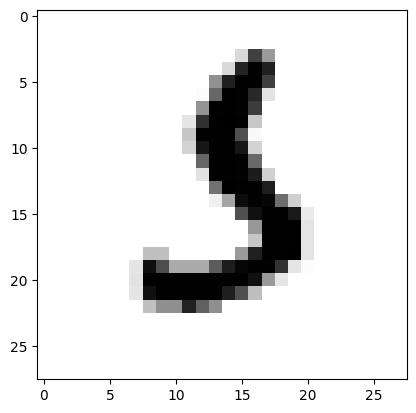

test 445: prediction = 0, truth is 6


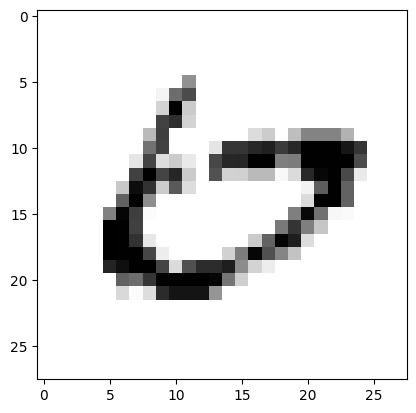

test 449: prediction = 5, truth is 3


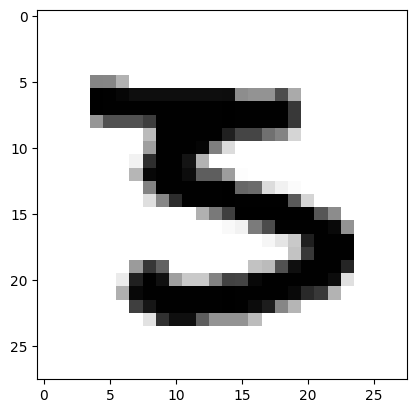

test 495: prediction = 0, truth is 8


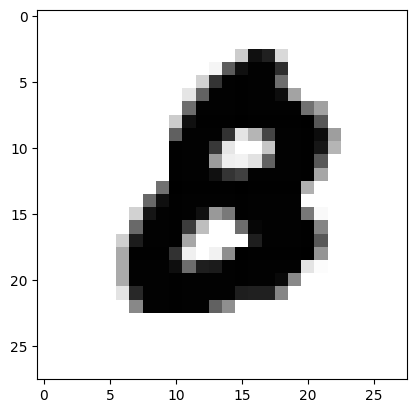

test 582: prediction = 2, truth is 8


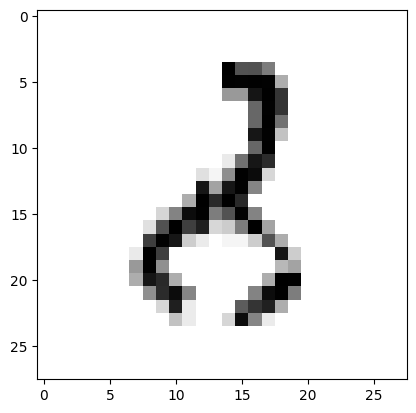

test 619: prediction = 8, truth is 1


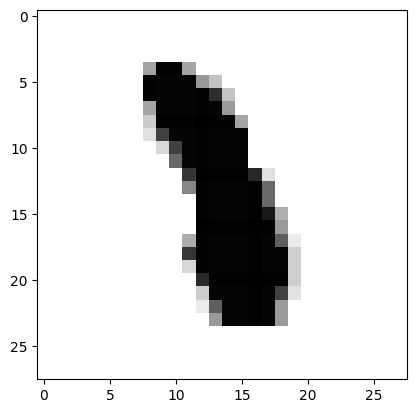

test 659: prediction = 7, truth is 2


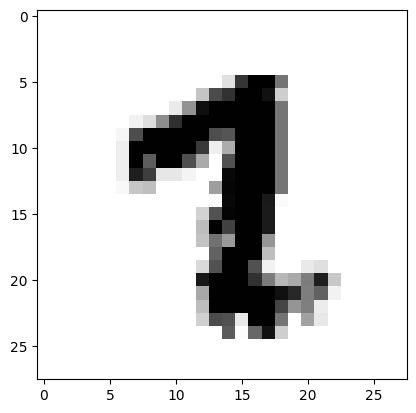

In [20]:
wrong = 0
max_wrong = 10

for n, (x, y) in enumerate(zip(X_test, y_test)):
    try:
        res = model.predict(np.array([x]), verbose=0)
        if np.argmax(res) != np.argmax(y):
            print(f"test {n}: prediction = {np.argmax(res)}, truth is {np.argmax(y)}")
            plt.imshow(x.reshape(28, 28), cmap="gray_r")
            plt.show()
            wrong += 1
            if (wrong > max_wrong-1):
                break
    except KeyboardInterrupt:
        print("stopping")
        break


## Experimenting

There are a number of things we can play with to see how the network performance
changes:

* batch size

* adding or removing hidden layers

* changing the dropout

* changing the activation function

## Callbacks

Keras allows for callbacks each epoch to store some information.  These can allow you to,
for example, plot of the accuracy vs. epoch by adding a callback.  Take a look here for some inspiration:

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History


## Going Further

Convolutional neural networks are often used for image recognition, especially with larger images.  They use filter to try to recognize patterns in portions of images (A tile).  See this for a keras example: 

https://www.tensorflow.org/tutorials/images/cnn
